In [1]:
import xarray as xr
import glob
from xgcm import Grid
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

%pylab inline
import warnings
warnings.simplefilter('ignore') # filter some warning messages

Populating the interactive namespace from numpy and matplotlib


In [2]:
in_file = 'roho160_clim_GLORYS_20170115_to_20191130_zarr.nc'
lat1, lon1 = 59.7,4.8
lat2, lon2 = 59.2,5
# choose a variiable and season to plot
var = 'u'
seasn = 2

seasons_nm = ['DJF','MAM','JJA','SON']
print(in_file)
print('Point 1: ', lat1,'N, ',lon1,'W')
print('Point 2: ', lat2,'N, ',lon2,'W')
print('Variable: ',var)
print('Season: ', seasons_nm[seasn])

roho160_clim_GLORYS_20170115_to_20191130_zarr.nc
Point 1:  59.7 N,  4.8 W
Point 2:  59.2 N,  5 W
Variable:  u
Season:  JJA


In [3]:
def compute_depth_layers(ds, grid, hmin=0.1): 
    ## from https://raphaeldussin.medium.com/modern-python-tools-for-the-roms-ocean-model-bfca8642db01

    """ compute depths of ROMS vertical levels (Vtransform = 2) """
    
    # compute vertical transformation functional
    S_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    S_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    
    # compute depth of rho (layers) and w (interfaces) points
    z_rho = ds.zeta + (ds.zeta + ds.h) * S_rho
    z_w = ds.zeta + (ds.zeta + ds.h) * S_w
    
    # transpose arrays and fill NaNs with a minimal depth
    ds['z_rho'] = z_rho.transpose(*('season', 's_rho','yh','xh'),
                                  transpose_coords=False).fillna(hmin)
    
    ds['z_w'] = z_w.transpose(*('season', 's_w','yh','xh'),
                                  transpose_coords=False).fillna(hmin)
    
    # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
    
    # compute layer thickness as difference between interfaces
    ds['dz'] = grid.diff(ds['z_w'], 'Z')
    
    # add z_rho and z_w to xarray coordinates
    ds = ds.set_coords(['z_rho', 'z_w', 'z_v', 'z_u'])
    
    return ds


In [4]:
def rot_coords(ds):
    # modified from Trond's functions
    # https://github.com/trondkr/romstools/blob/master/VolumeFlux/tools.py

    # converto to curvilinear coordinates
    # calculate u,v in xh,yh grid points
    u_rho = (ds.u[:,:,:,:-1].values+ds.u[:,:,:,1::].values)/2.0
    v_rho = (ds.v[:,:,:-1,:].values+ds.v[:,:,1::,:].values)/2.0
    print(np.shape(u_rho),np.shape(v_rho))

    # for each vertical level
    angle = np.full((np.shape(v_rho)),np.nan)
    for iy,i in enumerate(ds.s_rho.values):
        angle[:,iy,:,:] = ds.angle.values
    print("angle : {}".format(np.shape(angle)))
    u=u_rho
    v=v_rho
    print("u : {} v: {}".format(np.shape(u), np.shape(v)))


    u_rotated = u*np.cos(angle)-v*np.sin(angle)
    v_rotated = v*np.cos(angle)+u*np.sin(angle)
    print("u : {} and v: {}".format(np.shape(u_rotated),
                                    np.shape(v_rotated)))

    cv_dz = xr.DataArray(
                name="u",
                data=u_rotated,
                coords={'season': (['season'],['DJF','JJA','MAM','SON']), 
                        's_rho': (['s_rho'], ds.s_rho.values),
                        'lat': (['yh','xh'], ds["lat_rho"].values),
                        'lon': (['yh','xh'], ds["lon_rho"].values),
                        'z_rho': (['season','s_rho','yh', 'xh'],ds.z_rho.values)},
                dims=['season','s_rho',"yh","xh"]
            ).to_dataset()

    speed=np.square(u_rotated**2 + v_rotated**2)
    cv_dz["v"]=(['season','s_rho','yh', 'xh'],  v_rotated)
    cv_dz["speed"]=(['season','s_rho','yh', 'xh'],  speed)
    cv_dz["temp"]=(['season','s_rho','yh', 'xh'],  ds.temp.values)
    #print(cv_dz)
    
    return cv_dz

In [5]:
def line_points(temp):
    # modified from Trond's functions
    # https://github.com/trondkr/romstools/blob/master/VolumeFlux/tools.py

    # find indices for both points
    lo = temp.lon.values - lon1
    la = temp.lat.values - lat1
    diff = (lo*lo) + (la*la)
    jj1, ii1 = np.where(diff==diff.min())
    jj1 = jj1[0]
    ii1 = ii1[0]
    print(jj1,ii1, 'yh,xh')
    lo = temp.lon.values - lon2
    la = temp.lat.values - lat2
    diff = (lo*lo) + (la*la)
    jj2, ii2 = np.where(diff==diff.min())
    jj2 = jj2[0]
    ii2 = ii2[0]
    #print(jj2,ii2, 'yh,xh')
    #print(temp.lon[jj1,ii1].values, temp.lat[jj1,ii1].values)
    #print(temp.lon[jj2,ii2].values, temp.lat[jj2,ii2].values)

    # find the line - in indices
    if ii1 != ii2:
        aj = (jj2 - jj1)/(ii2-ii1)
        bj = jj1 - aj * ii1
    if jj1 != jj2:
        ai = (ii2 - ii1)/(jj2-jj1)
        bi = ii1 - ai * jj1

    if (abs(aj)) <= 1:
        if (ii2<ii1): #swap
            i = ii1
            j = jj1
            ii1 = ii2
            jj1 = jj2
            ii2 = i
            jj2 = j

        # nearest
        n = 0
        near = np.zeros((ii2-ii1+1,5))

        for i in range(ii1,ii2+1):
            j = aj*i + bj
            near[n,0]=i
            near[n,1]=j
            near[n,2]=np.floor(j)
            near[n,3]=np.ceil(j)
            near[n,4]=np.round(j)
            n += 1

    else:
        if (jj2<jj1): #swap
            i = ii1
            j = jj1
            ii1 = ii2
            jj1 = jj2
            ii2 = i
            jj2 = j

        # nearest
        n = 0
        near = np.zeros((jj2-jj1+1,5))
        for j in range(jj1,jj2+1):
            i = ai*j + bi
            near[n,0]=j
            near[n,1]=i
            near[n,2]=np.floor(i)
            near[n,3]=np.ceil(i)
            near[n,4]=np.round(i)
            n += 1
            
    return near, aj

In [6]:
def v_transect(temp, near, aj):
    # modified from Trond's functions
    # https://github.com/trondkr/romstools/blob/master/VolumeFlux/tools.py

    # calculate vertical transect
    transect = np.zeros((temp.z_rho.shape[0],near.shape[0]))
    for n in range(near.shape[0]):
        if (abs(aj)<=1):
            if (near[n,2]==near[n,3]):
                transect[:,n] = temp[int(near[n,2]), int(near[n,0]),:]
            else:
                transect[:,n] = (int(near[n,1]) - int(near[n,2])) * temp[int(near[n,3]), int(near[n,0]),:] + \
                                (int(near[n,3]) - int(near[n,1])) * temp[int(near[n,2]), int(near[n,0]),:]
        else:
            if (near[n,2] == near[n,3]):
                transect[:,n] = temp[int(near[n,0]), int(near[n,2]),:]
            else:
                 transect[:,n] = (int(near[n,1]) - int(near[n,2])) * temp[int(near[n,0]), int(near[n,3]), :] + \
                                 (int(near[n,3]) - int(near[n,1])) * temp[int(near[n,0]), int(near[n,2]), :]

    # lats and lons of line 
    lons = np.zeros(near.shape[0])
    lats = np.zeros(near.shape[0])
    l = near.shape[0]
    if lon2-lon1<0: # flip
        for i in range(near.shape[0]):
            lons[i]=temp.lon[near[l-i-1,0].astype(int),near[l-i-1,4].astype(int)].values
            lats[i]=temp.lat[near[l-i-1,0].astype(int),near[l-i-1,4].astype(int)].values
    else:
        for i in range(near.shape[0]):
            lons[i]=temp.lon[near[i,0].astype(int),near[i,4].astype(int)].values
            lats[i]=temp.lat[near[i,0].astype(int),near[i,4].astype(int)].values
            
    return transect, lats, lons

In [7]:
# open zarr file
dz = xr.open_zarr(in_file, consolidated=True)

# calculate climatology
dz_clim = dz.groupby('time.season').mean('time',keep_attrs=True)
#dz_clim

In [8]:
# Create xgcm grid object
grid_dz = Grid(dz_clim, coords={'X': {'center': 'xh', 'outer': 'xq'},
                               'Y': {'center': 'yh', 'outer': 'yq'},
                               'Z': {'center': 's_rho', 'outer': 's_w'}},
                 periodic=False)

# Add depths of layers and interfaces to dataset
dz_clz = compute_depth_layers(dz_clim, grid_dz)
#dz_clz

cv_dz = rot_coords(dz_clz) # transform to curvilinear coordinates

(4, 40, 959, 1439) (4, 40, 959, 1439)
angle : (4, 40, 959, 1439)
u : (4, 40, 959, 1439) v: (4, 40, 959, 1439)
u : (4, 40, 959, 1439) and v: (4, 40, 959, 1439)


522 524 yh,xh


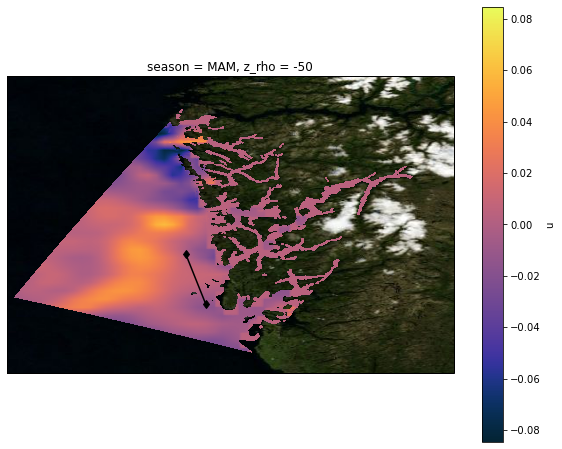

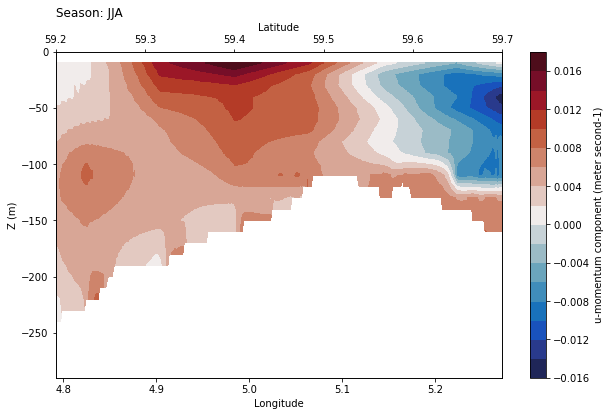

In [9]:
# transform vertical coordinates on one variable
target_depth_levels = np.arange(0,-300,-10)
snapshot = cv_dz.isel(season=seasn)
sndz = grid_dz.transform(snapshot[var], 'Z', target_depth_levels, target_data=snapshot['z_rho'], method='linear')

# plot at -50 depth to show line
plt.figure(figsize=[10,8])
ax = plt.axes(projection=ccrs.PlateCarree())
p = sndz.sel(z_rho=-50).plot(ax=ax, x='lon', y='lat',
                   cmap=cmocean.cm.thermal,
                   add_labels=True,
                   transform=ccrs.PlateCarree())
plt.plot([lon1,lon2],[lat1,lat2],'kd-')
# background
url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
p.axes.add_wmts(url, 'BlueMarble_NextGeneration')
p.axes.set_extent([3,7.5,58.5,61.5])

pnts, aj = line_points(sndz)
transect, lats, lons = v_transect(sndz, pnts, aj)


fig = plt.figure(figsize=[10,6])
ax1 = fig.add_subplot(111)
plt.contourf(lons,sndz.z_rho,transect, 20,cmap=cmocean.cm.balance)
cbar = plt.colorbar()
cbar.set_label(dz_clim[var].long_name+' ('+dz_clim[var].units+')')
plt.ylabel('Z (m)')
plt.xlabel('Longitude')
ax2 = ax1.twiny()
ax2.plot(lats, np.full(len(lats), np.nan)) # Create a dummy plot
ax2.cla()
xx = np.round(ax2.get_xticks() * (lats[-1]-lats[0])+lats[0],1)
ax2.set_xticklabels(xx)
plt.xlabel('Latitude')
plt.title('Season: '+seasons_nm[seasn],loc='left')
plt.show()
    